In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


rcParams['figure.figsize'] = 35, 10

In [2]:
data = pd.read_csv("restaurant-1-orders.csv")

In [6]:
data['Item Name'].value_counts()

Pilau Rice            4721
Plain Naan            3753
Plain Papadum         3598
Garlic Naan           2628
Onion Bhajee          2402
                      ... 
Tandoori Chicken         1
Lamb Persian             1
Chicken Chaat Main       1
Kurma                    1
Mushroom - Prawn         1
Name: Item Name, Length: 248, dtype: int64

In [7]:
#total products für die nächsten 7 tage (für die top 10 produkte)

data.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [3]:
#slect only needed columns
data_port = data[["Order Date", "Product Price", "Quantity", "Total products"]]

# drop NaN-Cases
data_port = data_port.dropna()

In [4]:
#change to datetime
data_port["Order Date"] = pd.to_datetime(data_port["Order Date"])
#data_port = data_port.set_index('Order Date')

In [5]:
data_ts = data_port[["Order Date", "Total products"]]

In [6]:
data_ts.rename(columns= {'Order Date':'ds', 'Total products':'y'}, inplace = True)

In [7]:
data_ts.sort_values(by='ds', inplace=True)

In [8]:
indexedDataset = data_ts.set_index(['ds'])

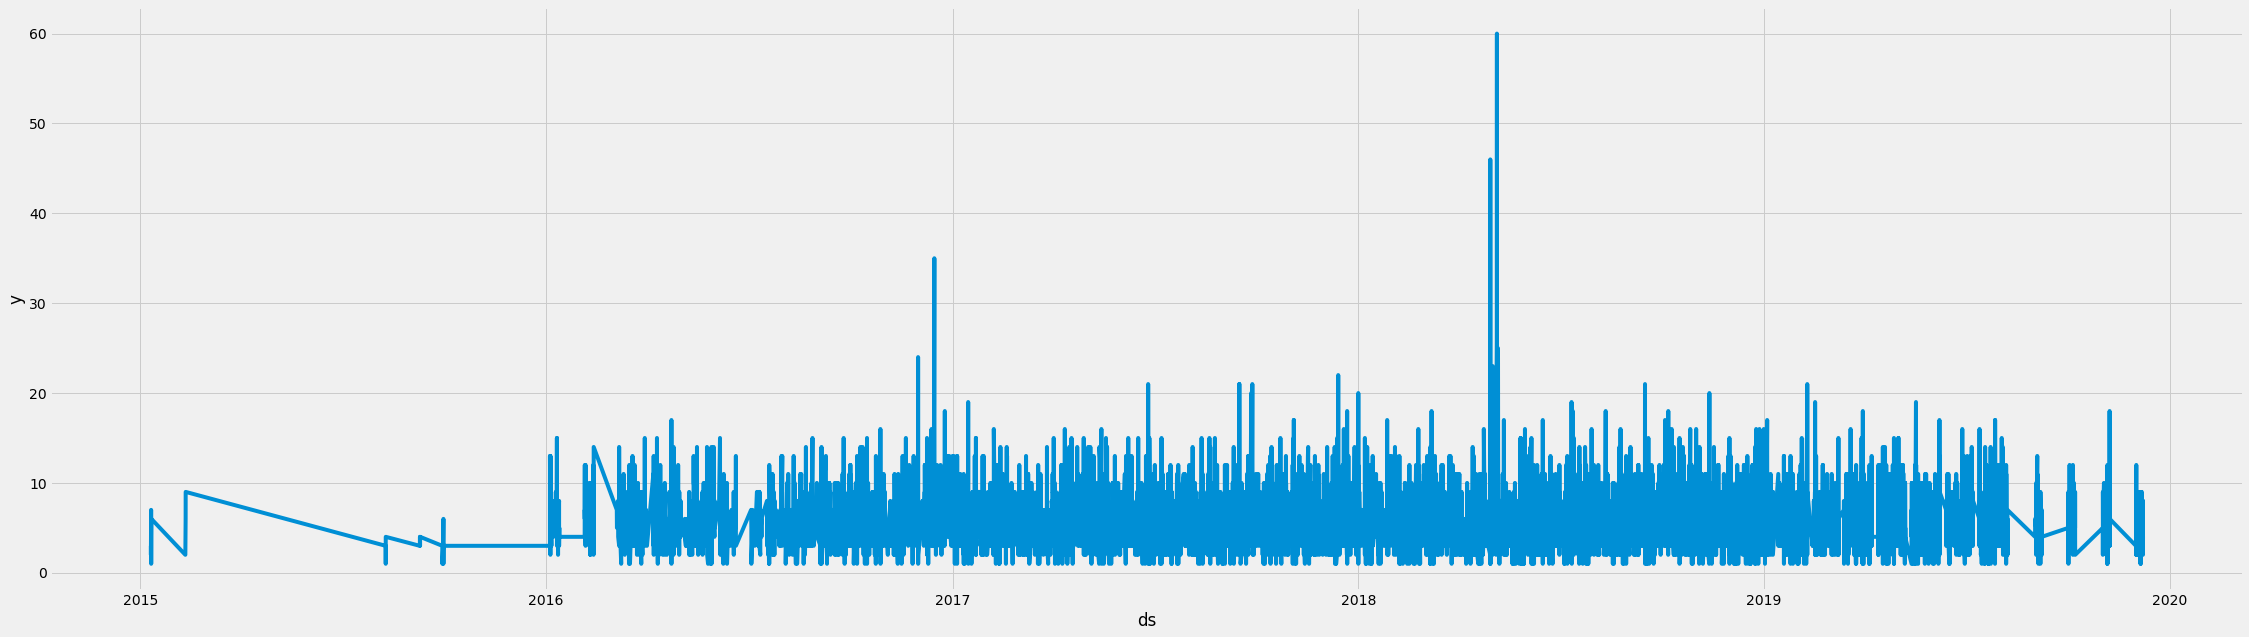

In [9]:
plt.xlabel('ds')
plt.ylabel('y')
plt.plot(indexedDataset)

# ARIMA https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima

<AxesSubplot:ylabel='Density'>

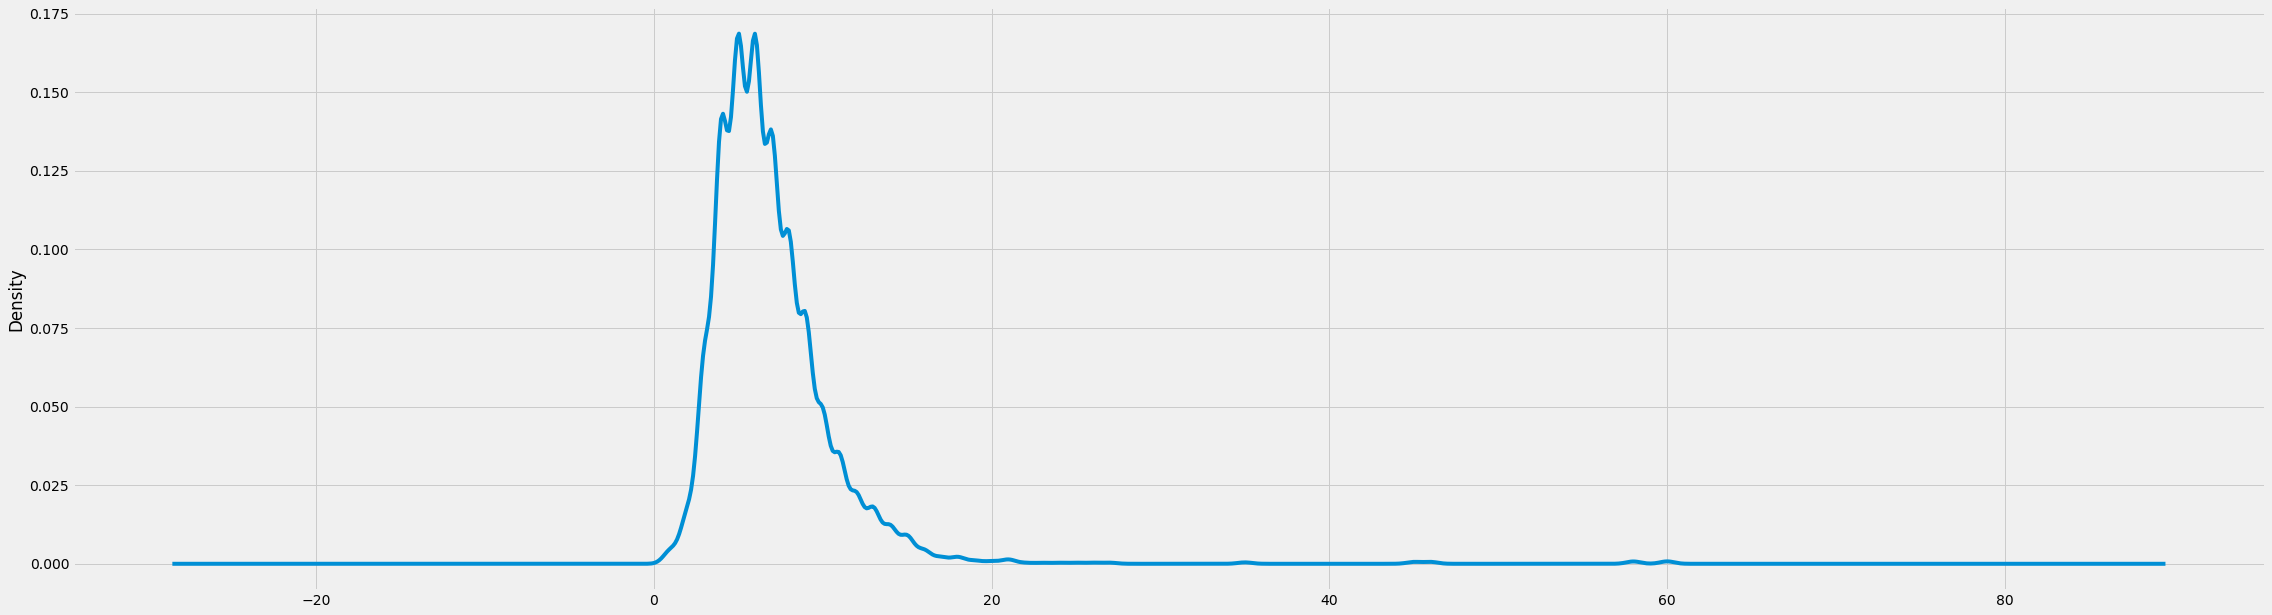

In [10]:
data_ts.y.plot(kind='kde')

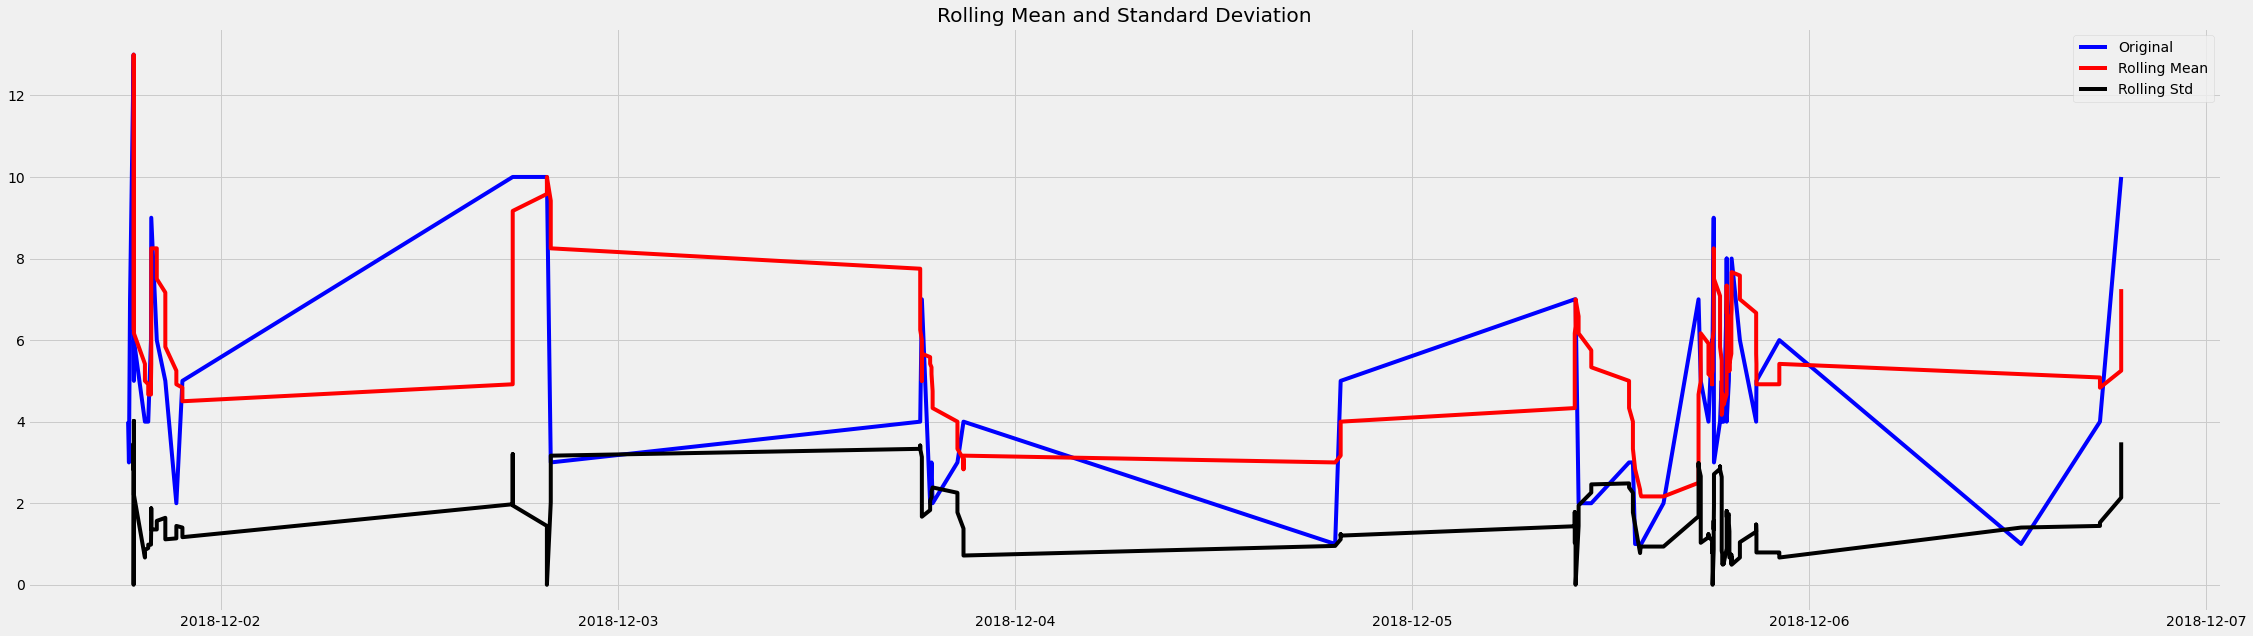

Results of dickey fuller test
Test Statistics                 -4.674589
p-value                          0.000094
No. of lags used                 0.000000
Number of observations used    299.000000
critical value (1%)             -3.452411
critical value (5%)             -2.871255
critical value (10%)            -2.571947
dtype: float64


In [11]:
#filterslide
indexedDataset=indexedDataset[len(indexedDataset)-20530:len(indexedDataset)-20230]

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(indexedDataset)

<Figure size 2520x720 with 0 Axes>

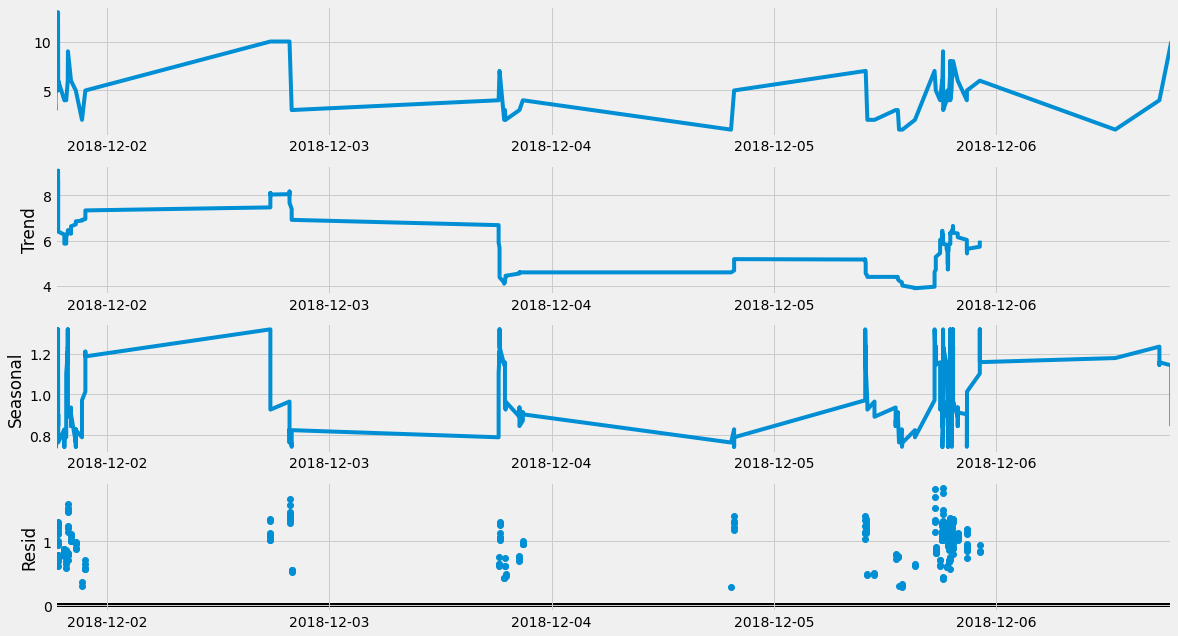

In [12]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(indexedDataset, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


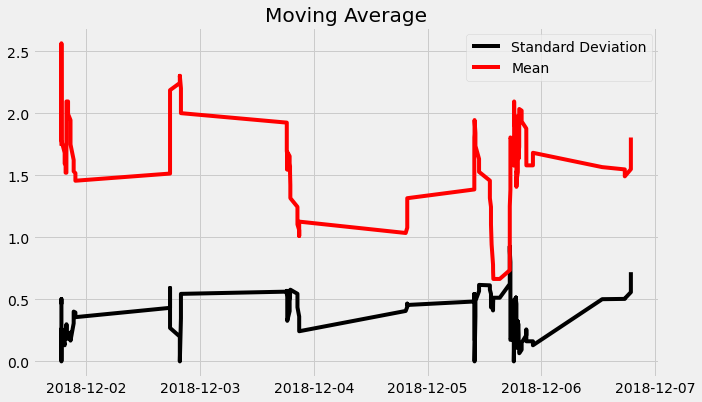

In [13]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(indexedDataset)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

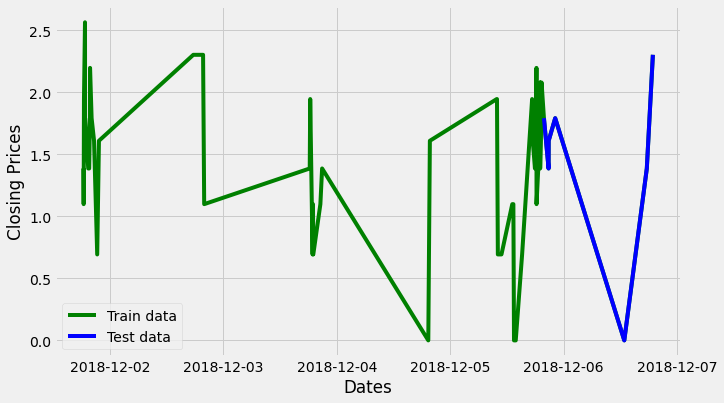

In [14]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1071.985, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=112.626, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=774.481, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=108.316, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=107.850, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=109.598, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=588.074, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=111.769, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=89.142, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=222.202, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=88.643, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=381.198, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=89.015, Time=0

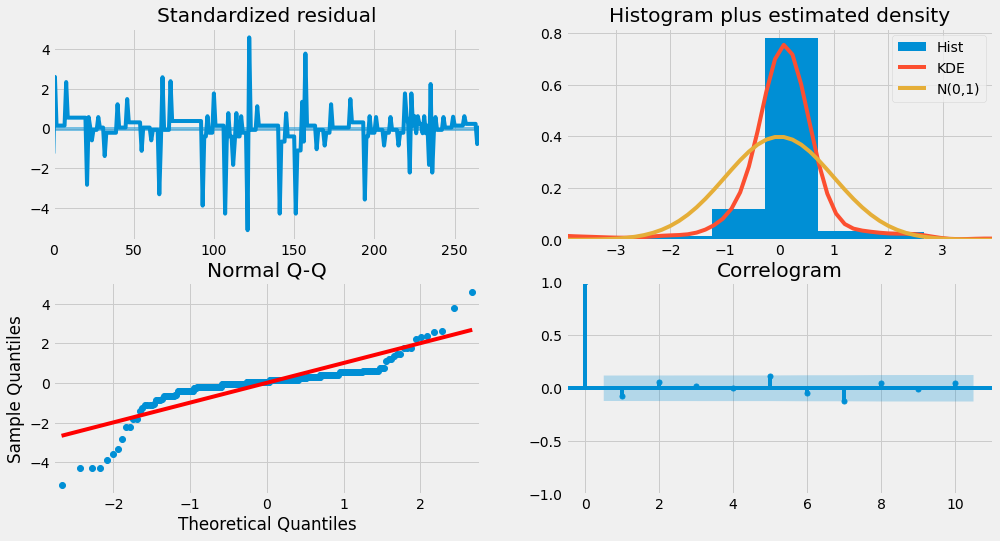

In [15]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [16]:
#Modeling
# Build Model

import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  267
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 -41.930
Date:                Sat, 25 Jun 2022   AIC                             91.861
Time:                        21:24:15   BIC                            106.195
Sample:                             0   HQIC                            97.619
                                - 267                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8547      0.050     17.125      0.000       0.757       0.952
ma.L1         -1.0923      0.210     -5.213      0.000      -1.503      -0.682
ma.L2          0.0930      0.071      1.308      0.1

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
anzahl=len(test_data)

In [18]:
fc = fitted.forecast(anzahl, alpha=0.05)
conf = fitted.get_forecast(anzahl, alpha=0.05).conf_int()
se = fitted.bse

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [19]:
index=test_data.index
fc_series = pd.Series(fc)
fc_series.index =index

In [20]:


lower_series = pd.Series(conf['lower y'])
lower_series.index = index

In [21]:


upper_series = pd.Series(conf['upper y'])
upper_series.index = index

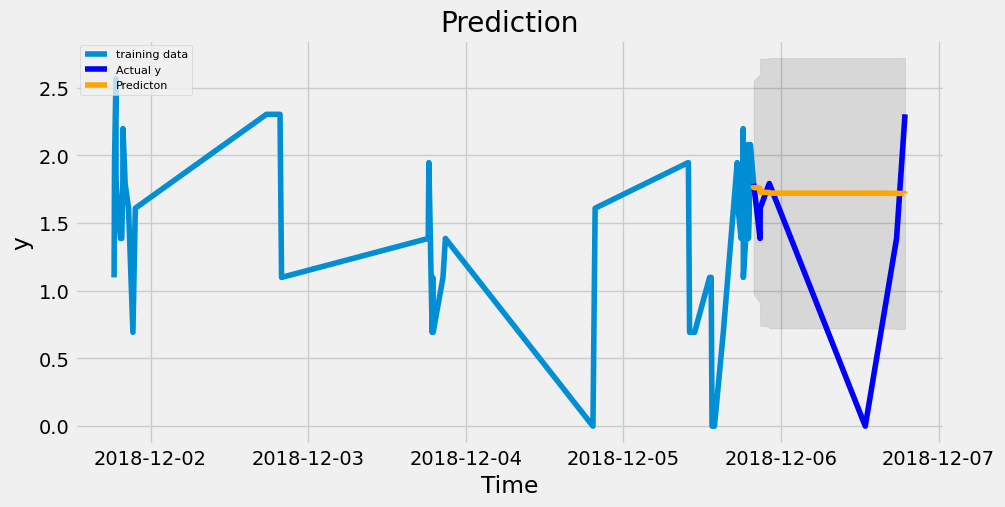

In [22]:
# Make as pandas series
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf['lower y'], index=test_data.index)
#upper_series = pd.Series(conf['upper y'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual y')
plt.plot(fc_series, color = 'orange',label='Predicton')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))


MSE: 0.21423149029985736
MAE: 0.3227277401747158
RMSE: 0.46285147758201806


### Fazit gute Bereichsvorhersage aber riesen nachteil dass ARIMA keine Seasionality unterstützt

# SAMIRA

In [4]:
df = pd.read_csv("restaurant-1-orders.csv")
#slect only needed columns
ds = df[["Order Date", "Product Price", "Quantity", "Total products"]]

# drop NaN-Cases
ds = ds.dropna()

In [5]:
#change to datetime
ds["Order Date"] = pd.to_datetime(ds["Order Date"])
#data_port = data_port.set_index('Order Date')

In [6]:

dd = ds[["Order Date", "Total products"]]
dd.rename(columns= {'Order Date':'ds', 'Total products':'y'}, inplace = True)
dd.sort_values(by='ds', inplace=True)
indexeddf = dd.set_index(['ds'])

#slider
indexeddf = indexeddf[len(indexeddf)-100:len(indexeddf)]

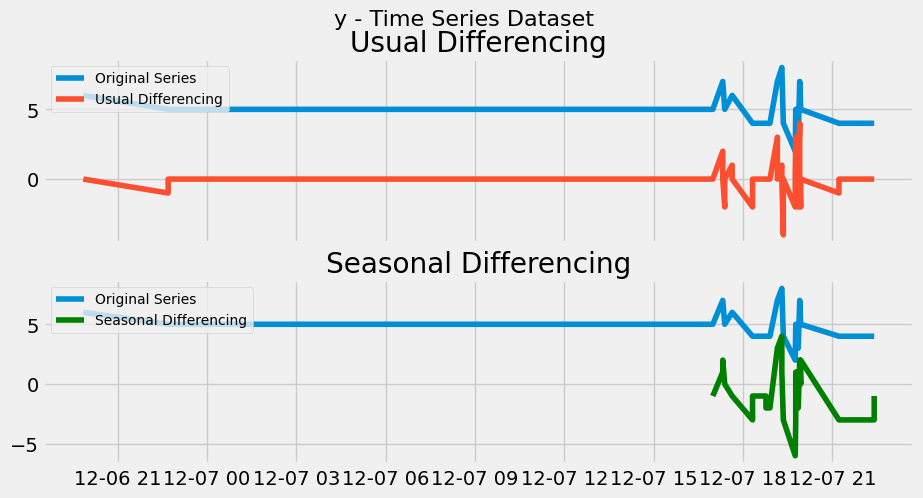

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(indexeddf[:], label='Original Series')
axes[0].plot(indexeddf[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(indexeddf[:], label='Original Series')
axes[1].plot(indexeddf[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('y - Time Series Dataset', fontsize=16)
plt.show()

In [8]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(indexeddf, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=305.104, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=280.182, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=306.282, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=269.544, Time=0.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=267.545, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=278.195, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=269.544, Time=0.10 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=269.537, Time=0.16

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -130.772
Date:                            Sat, 25 Jun 2022   AIC                            267.545
Time:                                    23:07:54   BIC                            274.943
Sample:                                         0   HQIC                           270.524
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7677      0.080     -9.599      0.000      -0.924      -0.611
ar.S.L24      -0.3942      0.104     -3.803      0.000      -0.597      -0.191
sigma2         1.0746      0.087     12.326      0.000       0.904       1.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               108.66
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.49   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

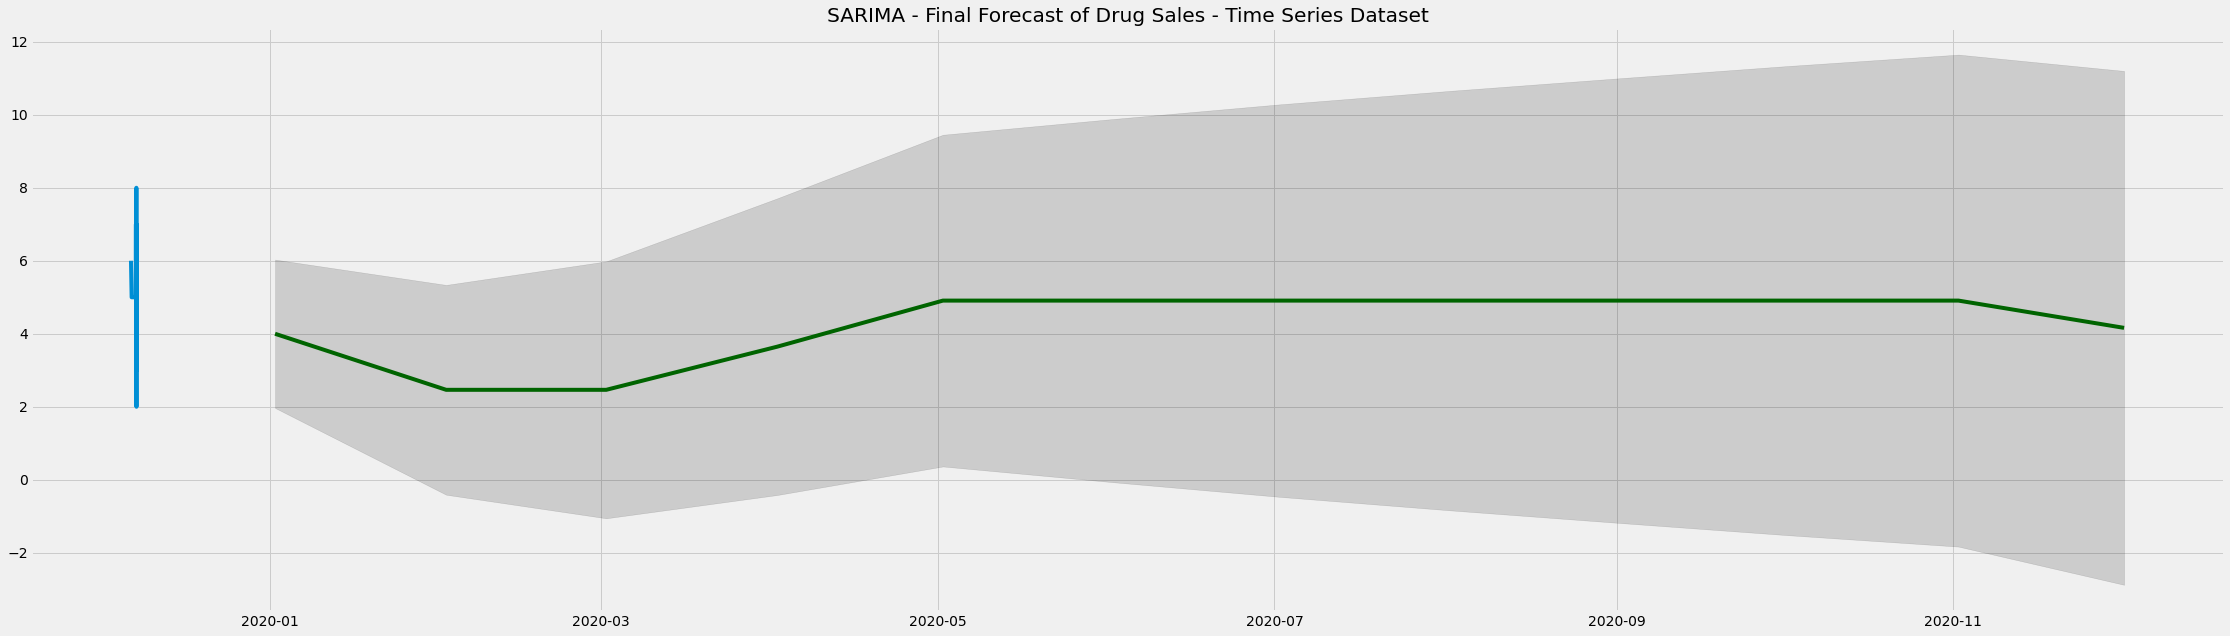

In [10]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexeddf.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(indexeddf)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()

# Modelle für die Top 2 Kategorien

In [61]:
data = pd.read_csv("restaurant-1-orders.csv")
data['Item Name'].value_counts()

Pilau Rice            4721
Plain Naan            3753
Plain Papadum         3598
Garlic Naan           2628
Onion Bhajee          2402
                      ... 
Tandoori Chicken         1
Lamb Persian             1
Chicken Chaat Main       1
Kurma                    1
Mushroom - Prawn         1
Name: Item Name, Length: 248, dtype: int64

## 1 Model: ARIMA Cat: Pilau Rice

In [62]:
data.head()

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6


In [63]:
ds=data[data['Item Name']== 'Pilau Rice']

In [64]:
#slect only needed columns
data_port = ds[["Order Date", "Product Price", "Quantity", "Total products"]]
# drop NaN-Cases
data_port = data_port.dropna()

In [65]:

#change to datetime
data_port["Order Date"] = pd.to_datetime(data_port["Order Date"])
#data_port = data_port.set_index('Order Date')

In [66]:

data_ts = data_port[["Order Date", "Total products"]]

In [67]:

data_ts

,Order Date,Total products
24,2019-03-08 20:01:00,7
29,2019-03-08 19:42:00,5
36,2019-03-08 19:29:00,4
65,2019-03-08 19:25:00,15
73,2019-03-08 19:16:00,4
...,...,...
29742,2016-03-18 19:24:00,5
29744,2016-03-18 18:56:00,6
29745,2016-03-18 18:54:00,9
29756,2016-03-17 19:56:00,5


In [68]:
data_ts.rename(columns= {'Order Date':'ds', 'Total products':'y'}, inplace = True)

In [69]:
data_ts.sort_values(by='ds', inplace=True)

<AxesSubplot:>

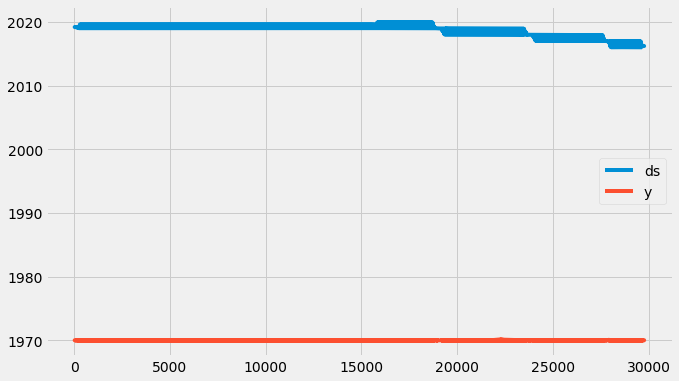

In [70]:


data_ts.plot()

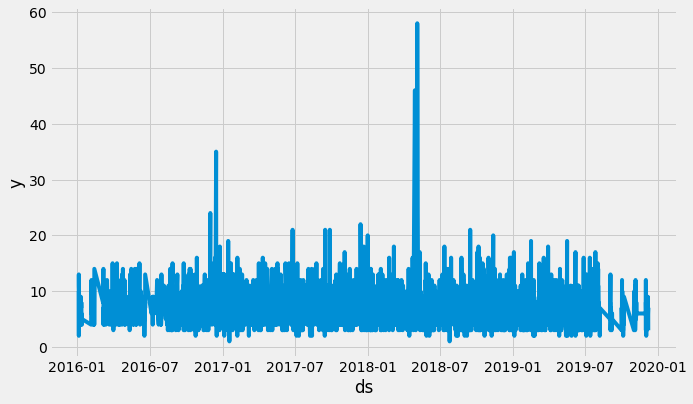

In [71]:
indexedDataset = data_ts.set_index(['ds'])

plt.xlabel('ds')
plt.ylabel('y')
plt.plot(indexedDataset)

In [72]:
indexedDataset

,y
ds,
2016-01-04 18:52:00,10
2016-01-04 19:33:00,7
2016-01-04 20:22:00,13
2016-01-04 21:07:00,2
2016-01-04 21:59:00,11
...,...
2019-12-06 18:42:00,9
2019-12-06 19:06:00,5
2019-12-07 17:19:00,7


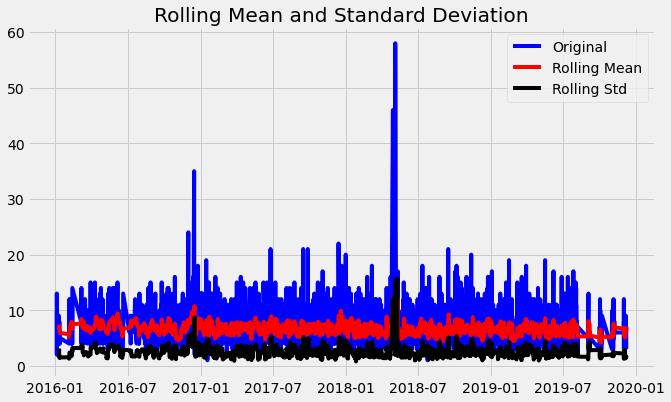

Results of dickey fuller test
Test Statistics               -1.216266e+01
p-value                        1.481392e-22
No. of lags used               2.100000e+01
Number of observations used    4.699000e+03
critical value (1%)           -3.431742e+00
critical value (5%)           -2.862155e+00
critical value (10%)          -2.567098e+00
dtype: float64


In [73]:
#filterslide
#indexedDataset=indexedDataset[len(indexedDataset)-200:len(indexedDataset)-150]

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(indexedDataset)

<Figure size 720x432 with 0 Axes>

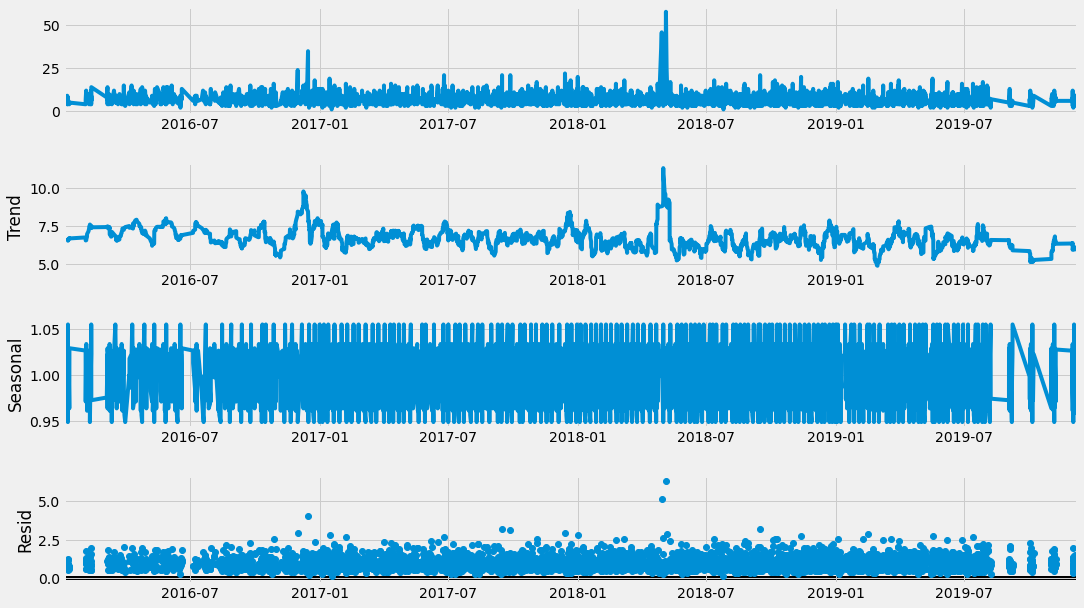

In [74]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(indexedDataset, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


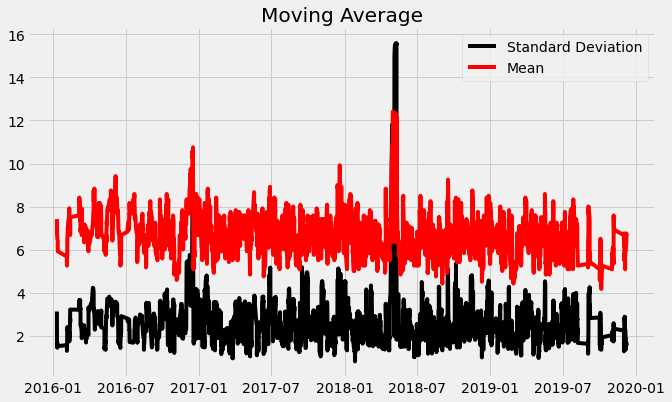

In [75]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

#df_log = np.log(indexedDataset)
df_log = indexedDataset


moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

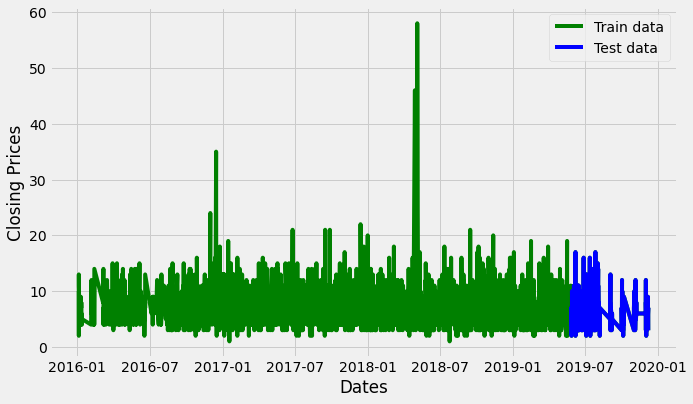

In [76]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=28896.087, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=23470.163, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=26462.740, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=22613.012, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=22245.800, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=21139.874, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=21138.068, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=21136.416, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21153.378, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21138.119, Time=1.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=21136.850, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=21140.064, Time=0.32 sec

Best model:  ARIMA(1,0,0)(0,0,

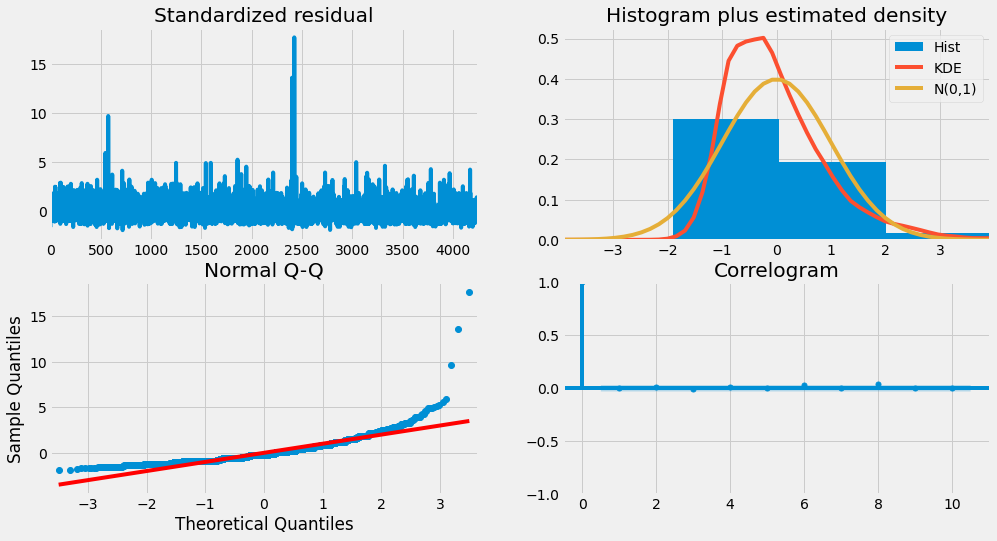

In [77]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [78]:
#Modeling
# Build Model

import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4245
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -10568.016
Date:                Sun, 03 Jul 2022   AIC                          21144.032
Time:                        15:40:47   BIC                          21169.445
Sample:                             0   HQIC                         21153.013
                               - 4245                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9958      0.005   -197.935      0.000      -1.006      -0.986
ma.L1         -0.0056      0.006     -0.864      0.388      -0.018       0.007
ma.L2         -0.9903      0.006   -159.595      0.0

In [79]:
anzahl=len(test_data)
fc = fitted.forecast(anzahl, alpha=0.05)
conf = fitted.get_forecast(anzahl, alpha=0.05).conf_int()
se = fitted.bse

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [80]:


index=test_data.index
fc_series = pd.Series(fc)
fc_series.index =index

lower_series = pd.Series(conf['lower y'])
lower_series.index = index

upper_series = pd.Series(conf['upper y'])
upper_series.index = index

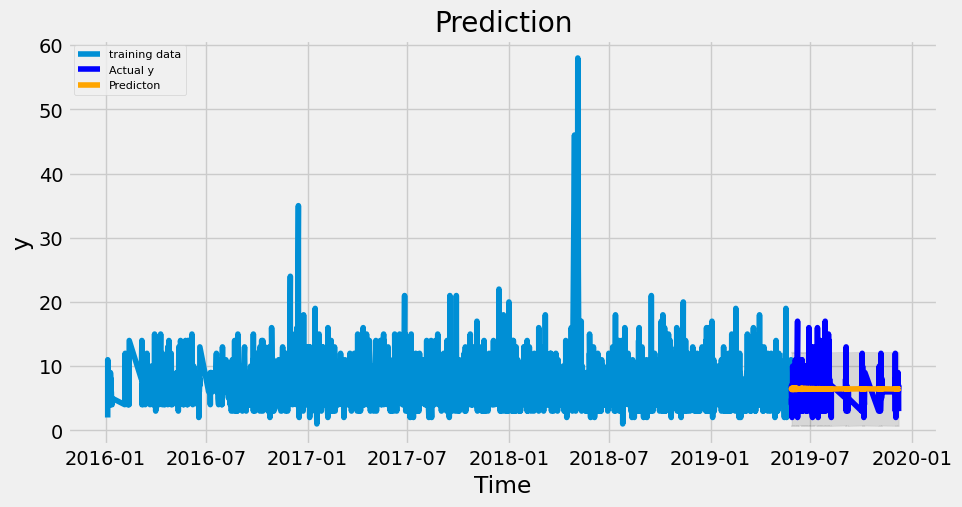

In [81]:
# Make as pandas series
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf['lower y'], index=test_data.index)
#upper_series = pd.Series(conf['upper y'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual y')
plt.plot(fc_series, color = 'orange',label='Predicton')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [82]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 6.776627805767062
MAE: 2.059356669954394
RMSE: 2.603195691024219


##  2 Model: ARIMA Cat: Plain Naan

In [39]:
data = pd.read_csv("restaurant-1-orders.csv")
ds=data[data['Item Name']== 'Plain Naan']
#slect only needed columns
data_port = ds[["Order Date", "Product Price", "Quantity", "Total products"]]
# drop NaN-Cases
data_port = data_port.dropna()
#change to datetime
data_port["Order Date"] = pd.to_datetime(data_port["Order Date"])
#data_port = data_port.set_index('Order Date')
data_ts = data_port[["Order Date", "Total products"]]
data_ts

,Order Date,Total products
6,2019-03-08 20:17:00,7
46,2019-03-08 19:28:00,8
88,2019-03-08 18:36:00,4
128,2019-03-08 17:18:00,5
134,2019-03-08 16:21:00,2
...,...,...
15500,2016-03-18 19:05:00,6
15501,2016-03-18 18:54:00,9
15502,2016-03-18 18:08:00,5
15503,2016-03-17 18:52:00,8


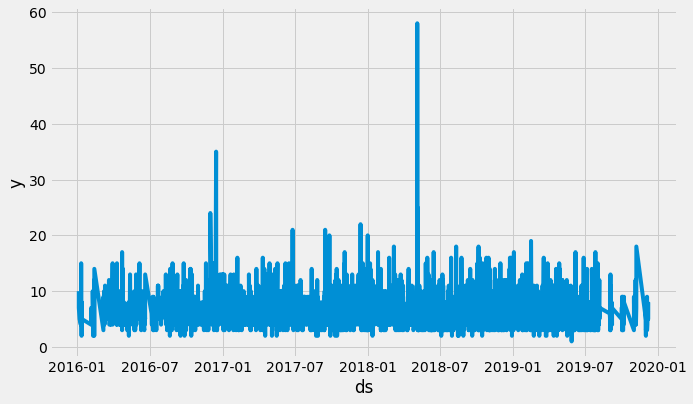

In [40]:
data_ts.rename(columns= {'Order Date':'ds', 'Total products':'y'}, inplace = True)
data_ts.sort_values(by='ds', inplace=True)
indexedDataset = data_ts.set_index(['ds'])

plt.xlabel('ds')
plt.ylabel('y')
plt.plot(indexedDataset)

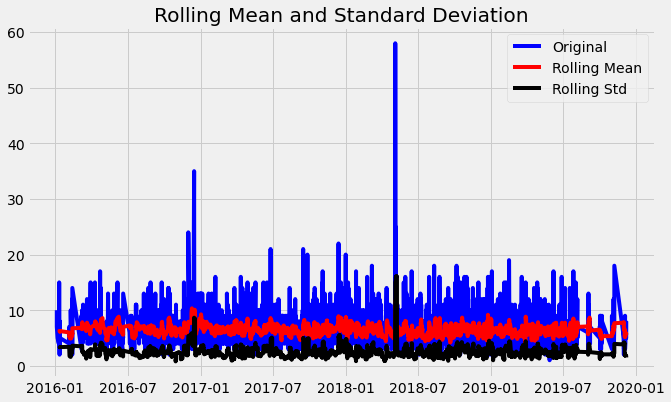

Results of dickey fuller test
Test Statistics                 -40.633443
p-value                           0.000000
No. of lags used                  1.000000
Number of observations used    3751.000000
critical value (1%)              -3.432095
critical value (5%)              -2.862311
critical value (10%)             -2.567180
dtype: float64


In [41]:
#filterslide
#indexedDataset=indexedDataset[len(indexedDataset)-200:len(indexedDataset)-150]

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(indexedDataset)

<Figure size 720x432 with 0 Axes>

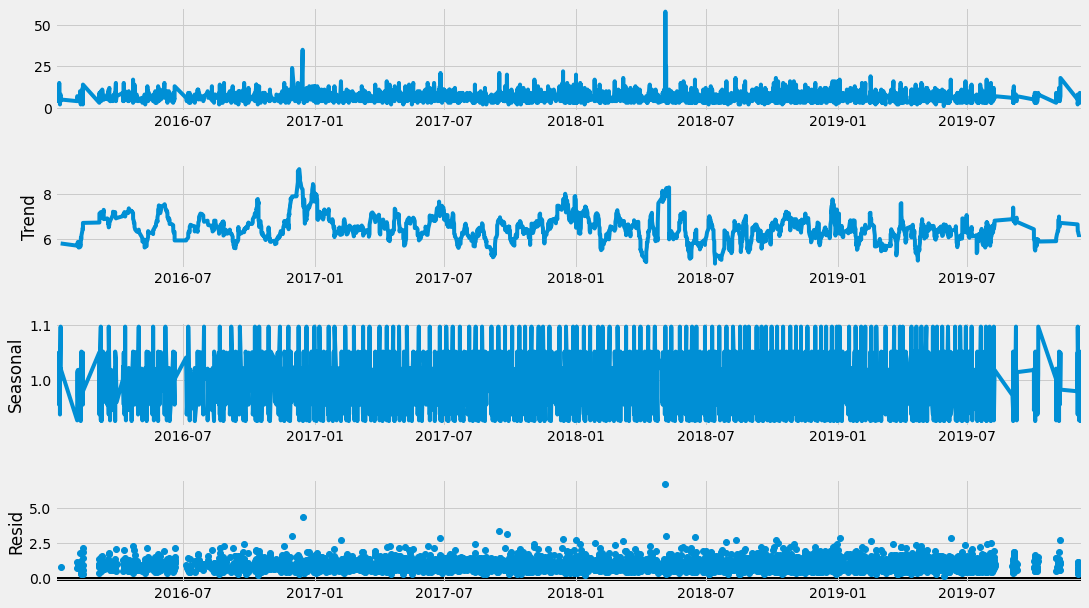

In [42]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(indexedDataset, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


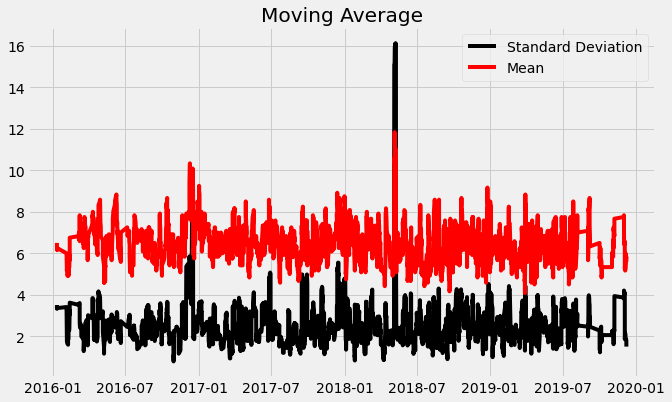

In [43]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

#df_log = np.log(indexedDataset)
df_log = indexedDataset

moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

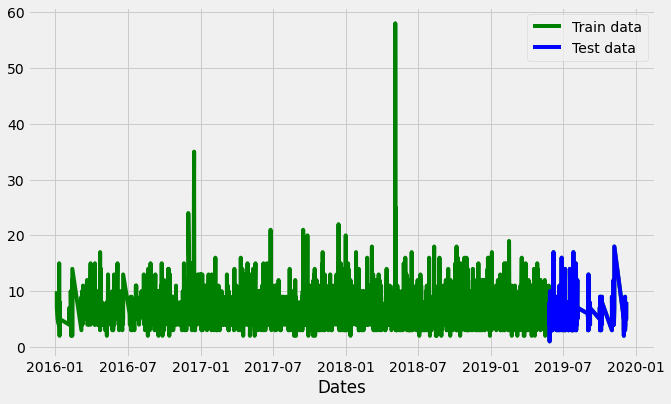

In [44]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')

plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22806.050, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=18695.500, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=21000.190, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=17850.186, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=17575.398, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=16726.384, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=16724.435, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16732.256, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=16726.430, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16728.996, Time=1.31 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=16728.384, Time=0.38 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 4.659 seconds
                     

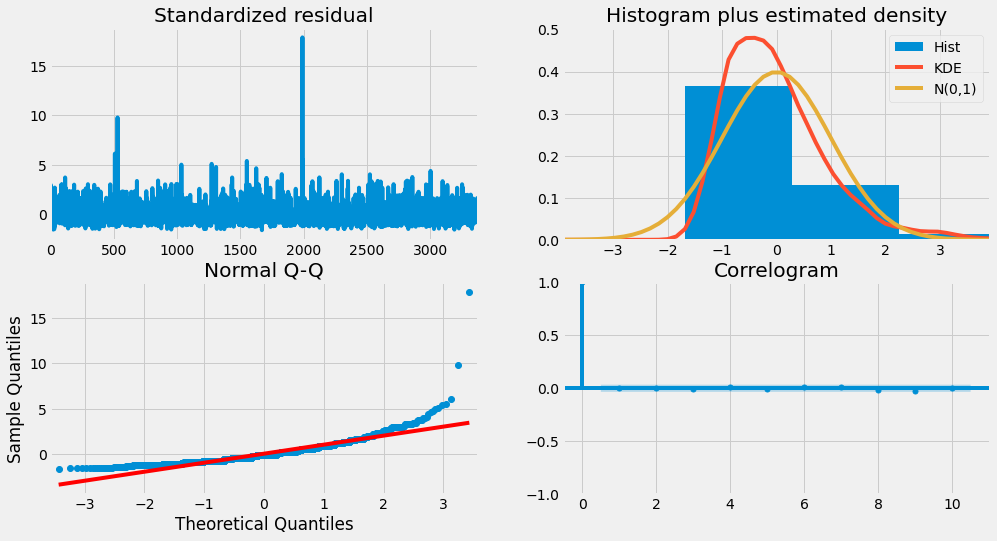

In [45]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [46]:
#Modeling
# Build Model

import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3374
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -8363.677
Date:                Sun, 03 Jul 2022   AIC                          16735.353
Time:                        15:36:15   BIC                          16759.847
Sample:                             0   HQIC                         16744.111
                               - 3374                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9789      1.270     -0.771      0.441      -3.468       1.511
ma.L1         -0.0184      1.273     -0.014      0.988      -2.513       2.476
ma.L2         -0.9761      1.269     -0.769      0.4

In [47]:
anzahl=len(test_data)
fc = fitted.forecast(anzahl, alpha=0.05)
conf = fitted.get_forecast(anzahl, alpha=0.05).conf_int()
se = fitted.bse

index=test_data.index
fc_series = pd.Series(fc)
fc_series.index =index

lower_series = pd.Series(conf['lower y'])
lower_series.index = index

upper_series = pd.Series(conf['upper y'])
upper_series.index = index

C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\fabcr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


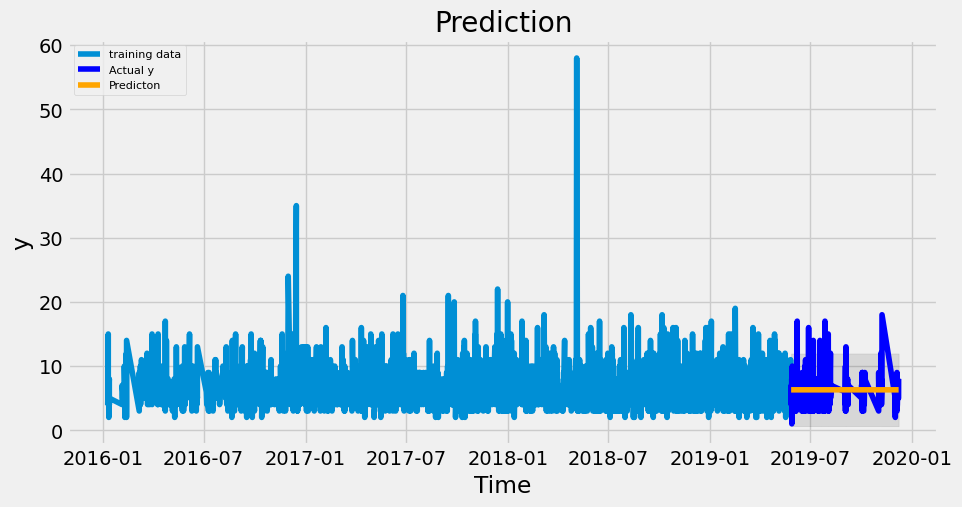

In [48]:
# Make as pandas series
#fc_series = pd.Series(fc, index=test_data.index)
#lower_series = pd.Series(conf['lower y'], index=test_data.index)
#upper_series = pd.Series(conf['upper y'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual y')
plt.plot(fc_series, color = 'orange',label='Predicton')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

MSE: 6.71558137916232
MAE: 2.013512631076928
RMSE: 2.591443879222994


## 3 Model: SARIMA Cat: Plain Naan

In [18]:
df = pd.read_csv("restaurant-1-orders.csv")
#slect only needed columns
ds = df[["Order Date", "Product Price", "Quantity", "Total products"]]

# drop NaN-Cases
ds = ds.dropna()
ds=data[data['Item Name']== 'Pilau Rice']

In [19]:
#change to datetime
ds["Order Date"] = pd.to_datetime(ds["Order Date"])
#data_port = data_port.set_index('Order Date')
dd = ds[["Order Date", "Total products"]]
dd.rename(columns= {'Order Date':'ds', 'Total products':'y'}, inplace = True)
dd.sort_values(by='ds', inplace=True)
indexeddf = dd.set_index(['ds'])

#slider
#indexeddf = indexeddf[len(indexeddf)-100:len(indexeddf)]

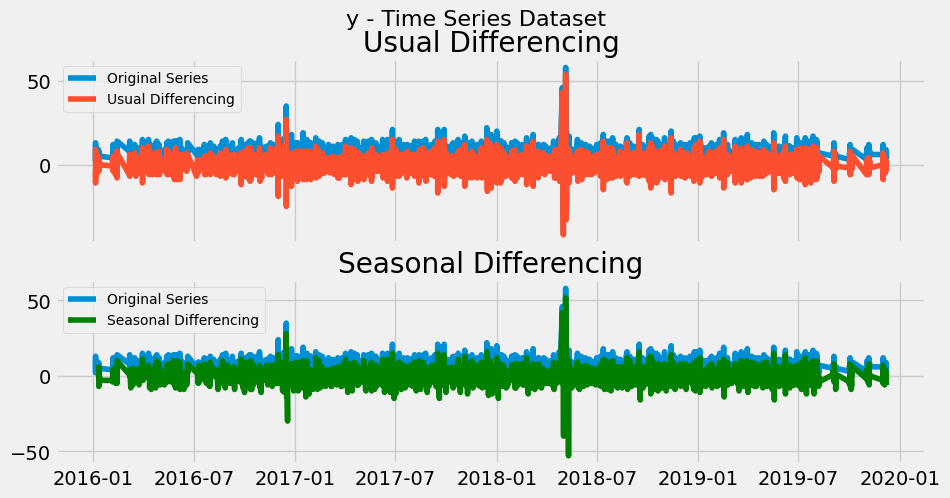

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(indexeddf[:], label='Original Series')
axes[0].plot(indexeddf[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(indexeddf[:], label='Original Series')
axes[1].plot(indexeddf[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('y - Time Series Dataset', fontsize=16)
plt.show()

In [22]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(indexeddf, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.27 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=26570.130, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=25247.564, Time=1.92 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=26568.132, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=26553.417, Time=0.36 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=24685.927, Time=7.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=32.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=10.90 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=24700.141, Time=6.55 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=24687.915, Time=8.91 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=24687.918, Time=14.43 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=24685.946, Time=7.20 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=24689.918, Time=12.12 sec
 ARIMA(1,0,0)(2,1,0)[12] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4721
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -12337.967
Date:                            Sun, 03 Jul 2022   AIC                          24683.935
Time:                                    15:17:36   BIC                          24709.763
Sample:                                         0   HQIC                         24693.015
                                           - 4721                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0587      0.009      6.396      0.000       0.041       0.077
ar.S.L12      -0.6588      0.007    -99.175      0.000      -0.672      -0.646
ar.S.L24      -0.3363      0.007    -48.735      0.000      -0.350      -0.323
sigma2        11.0339      0.071    154.976      0.000      10.894      11.173
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             73726.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

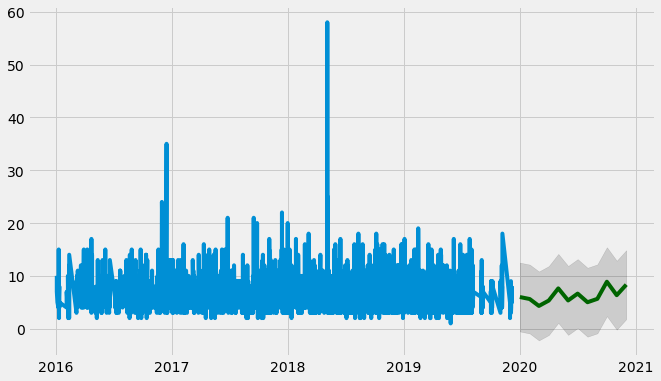

In [54]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexeddf.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(indexeddf)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)


plt.show()

## 4 Model: SARIMA Cat: Plain Naan

In [24]:
df = pd.read_csv("restaurant-1-orders.csv")
#slect only needed columns
ds = df[["Order Date", "Product Price", "Quantity", "Total products"]]

# drop NaN-Cases
ds = ds.dropna()
ds=data[data['Item Name']== 'Plain Naan']

In [25]:
#change to datetime
ds["Order Date"] = pd.to_datetime(ds["Order Date"])
#data_port = data_port.set_index('Order Date')
dd = ds[["Order Date", "Total products"]]
dd.rename(columns= {'Order Date':'ds', 'Total products':'y'}, inplace = True)
dd.sort_values(by='ds', inplace=True)
indexeddf = dd.set_index(['ds'])

#slider
#indexeddf = indexeddf[len(indexeddf)-100:len(indexeddf)]

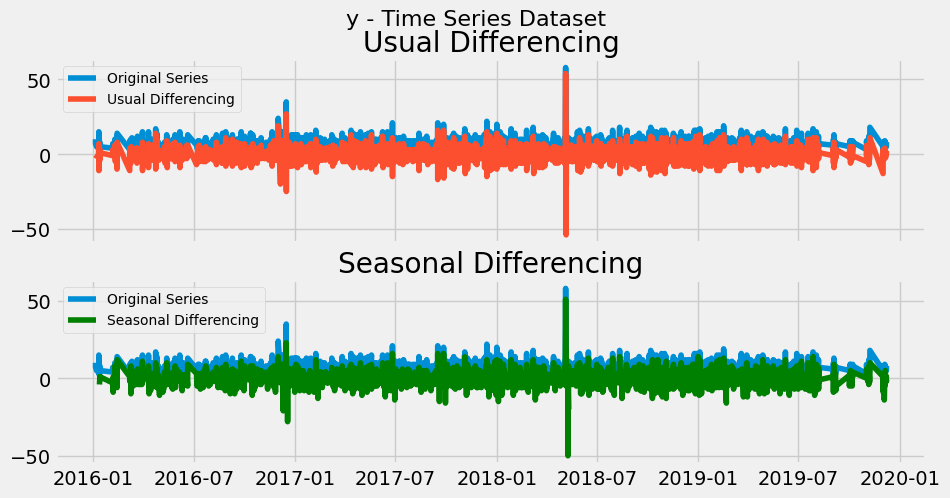

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(indexeddf[:], label='Original Series')
axes[0].plot(indexeddf[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(indexeddf[:], label='Original Series')
axes[1].plot(indexeddf[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('y - Time Series Dataset', fontsize=16)
plt.show()

In [27]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(indexeddf, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=21099.889, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=20036.523, Time=1.57 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=21097.891, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=21096.537, Time=0.30 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=19623.768, Time=6.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=25.65 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.75 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=19624.854, Time=5.24 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=19618.995, Time=7.06 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=20031.841, Time=1.75 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=27.42 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=11.04 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3753
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -9803.498
Date:                            Sun, 03 Jul 2022   AIC                          19616.995
Time:                                    15:21:01   BIC                          19648.131
Sample:                                         0   HQIC                         19628.070
                                           - 3753                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0275      0.016      1.727      0.084      -0.004       0.059
ar.L2          0.0425      0.010      4.182      0.000       0.023       0.062
ar.S.L12      -0.6590      0.008    -81.214      0.000      -0.675      -0.643
ar.S.L24      -0.3251      0.008    -41.885      0.000      -0.340      -0.310
sigma2        11.0409      0.081    136.292      0.000      10.882      11.200
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             55635.63
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             1.61
Prob(H) (two-sided):                  0.52   Kurtosis:                        21.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

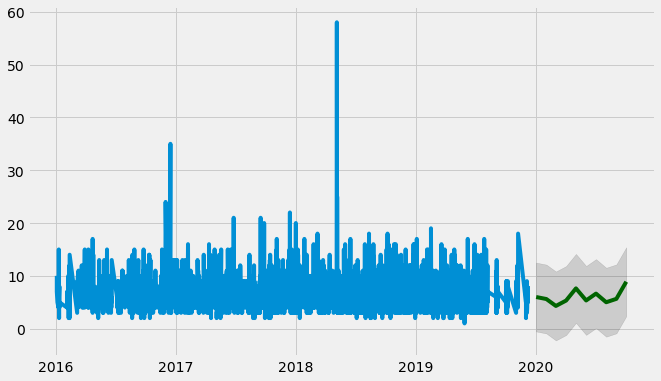

In [37]:
# Forecast
n_periods = 10
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexeddf.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(indexeddf)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()